# <b>Data Exploration</b>
Int this short notebook we use mediapipe to detect poses of the signers. The results are pictures with all the points plotted on them (for illustration purpose). But in practise we will explore the possiblity of using these points as input to a model, instead of complicated CNN model that might need too much computing power.

Note: The edited time of this notebook exceeded the submission time. I unfortunately did not save the changes and then rebooted my laptop.

In [1]:
!pip install -q mediapipe==0.10.0

In [2]:
from google.colab.patches import cv2_imshow # For running in Colab. Otherwise use matplotlib
import pandas as pd
import mediapipe as mp
import os
import json
import numpy as np
from mediapipe.framework.formats import landmark_pb2
import cv2

ModuleNotFoundError: No module named 'google.colab'

In [3]:
working_dir = '/content/drive/MyDrive/Colab Notebooks/AI/'
data_info = pd.read_csv(os.path.join(working_dir,'video_labels.csv'),dtype={'video_id': object})
data_info.head(2)

bbox  fps_x  frame_end  frame_start  instance_id  signer_id  \
0  [385, 37, 885, 720]     25         -1            1            0        118   
1  [462, 44, 949, 720]     25         -1            1           10         31   

       source  split                                                url  \
0    aslbrick  train       http://aslbricks.org/New/ASL-Videos/book.mp4   
1  signschool  train  https://signstock.blob.core.windows.net/signsc...   

   variation_id video_id  word      fps_y  width  height  duration  
0             0    69241  book  29.970030   1280     720   2.50250  
1             0    07069  book  23.976024   1280     720   1.25125

In [4]:
# Cell copied from a tutorial
# https://github.com/nicknochnack/ActionDetectionforSignLanguage/blob/main/Action%20Detection%20Tutorial.ipynb
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )
    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

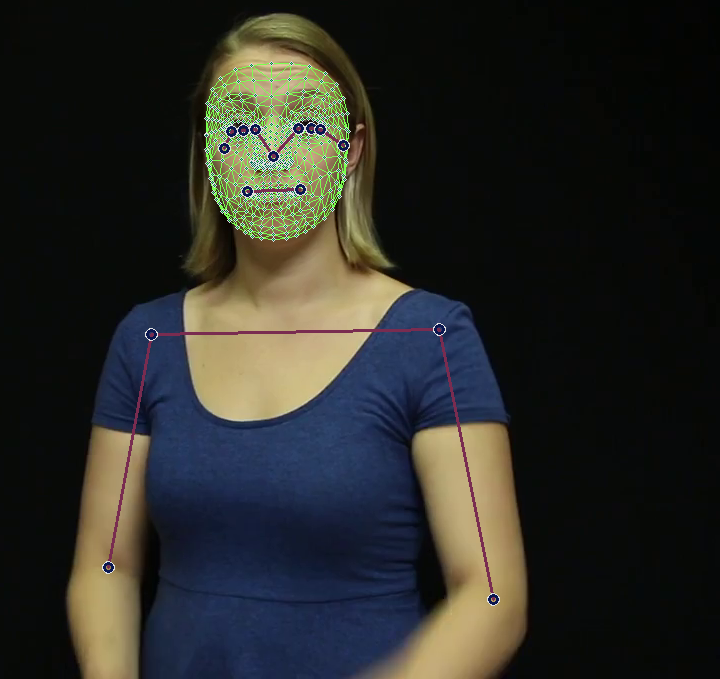

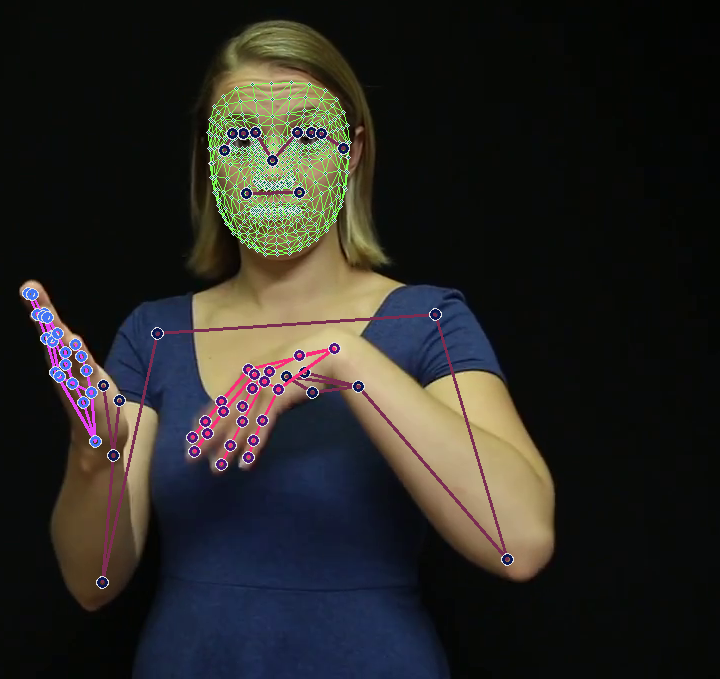

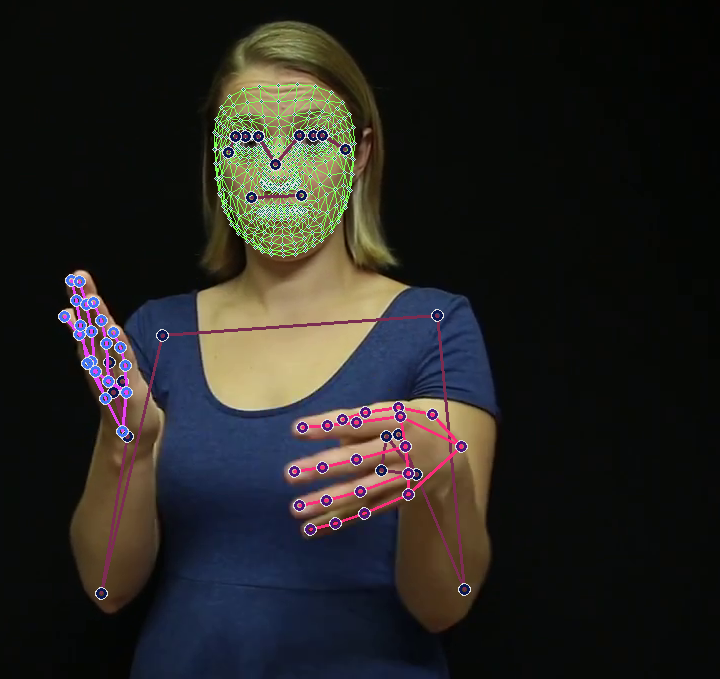

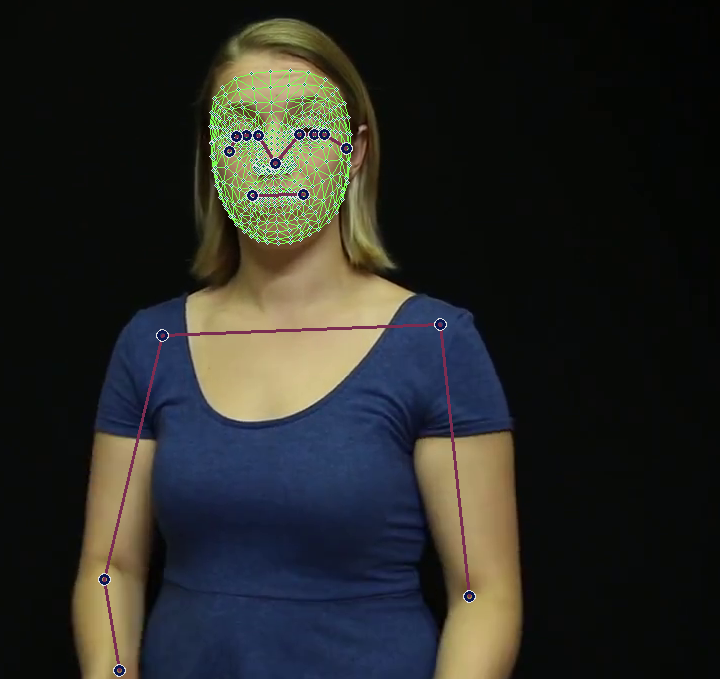

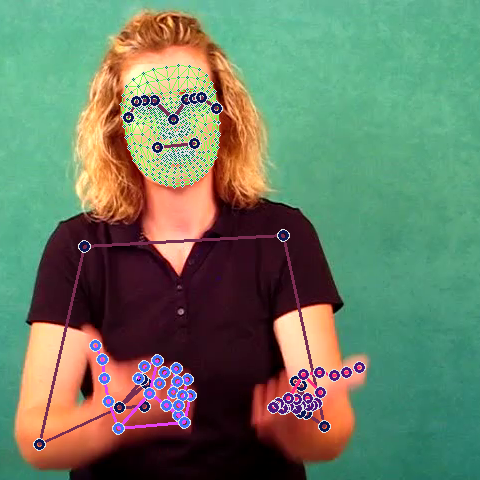

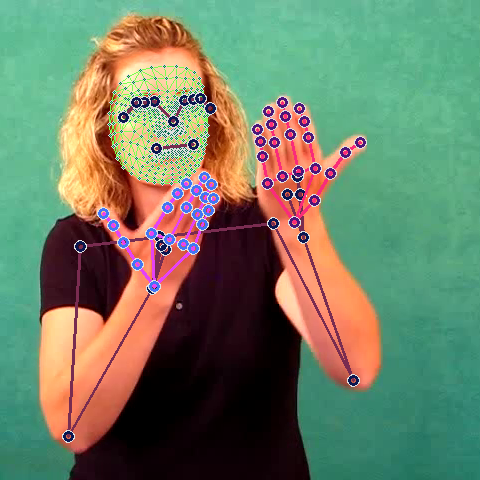

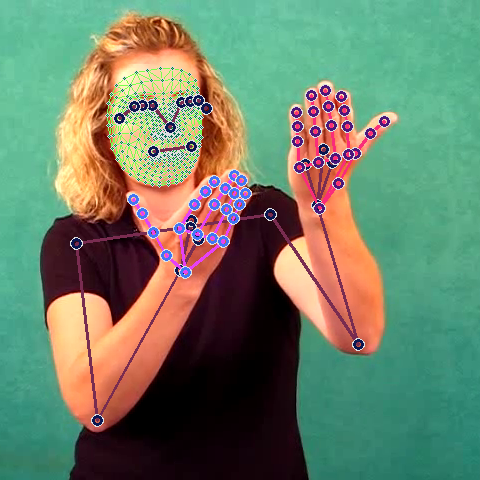

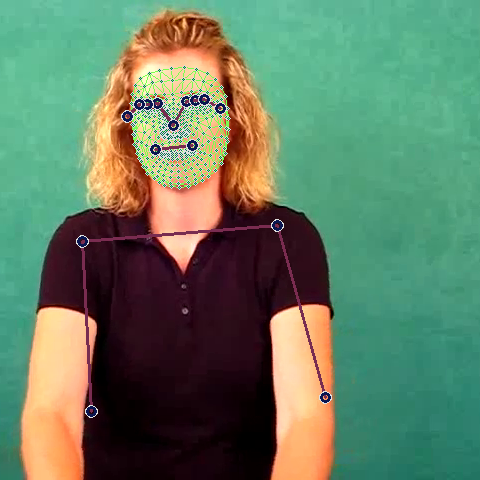

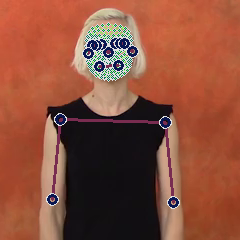

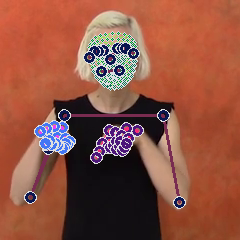

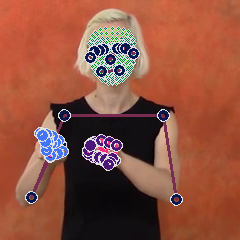

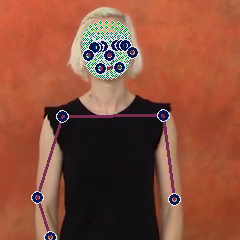

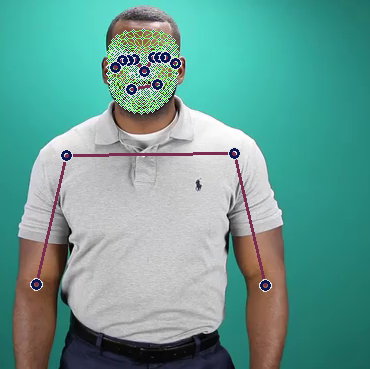

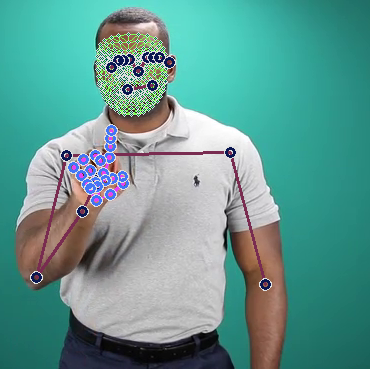

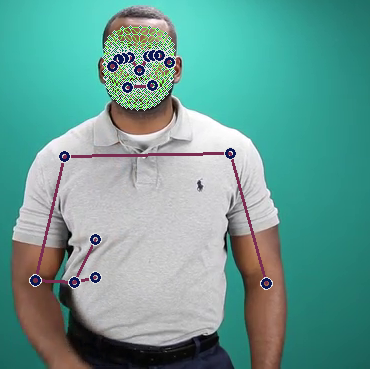

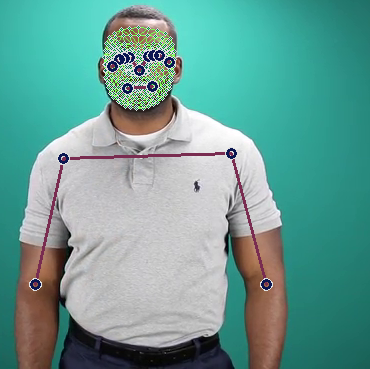

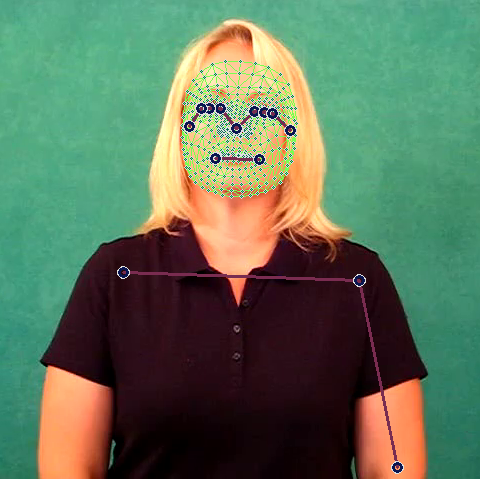

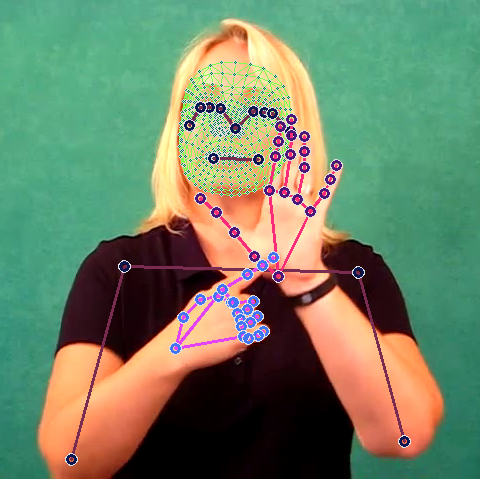

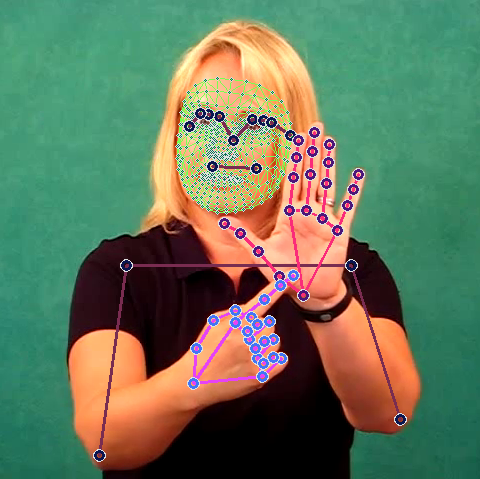

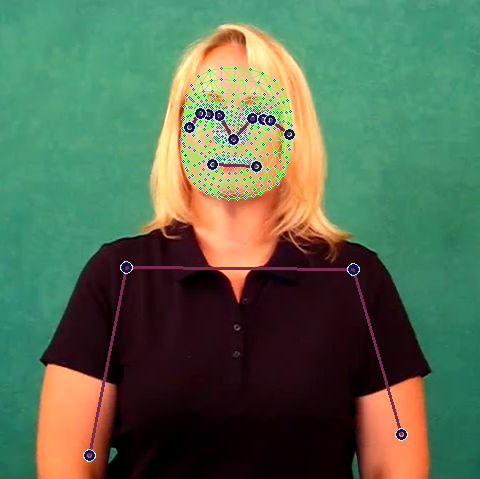

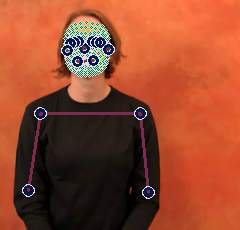

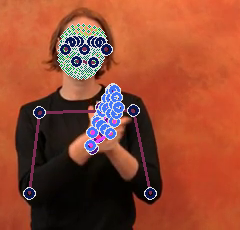

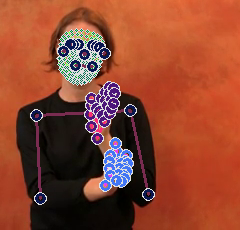

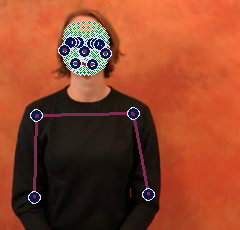

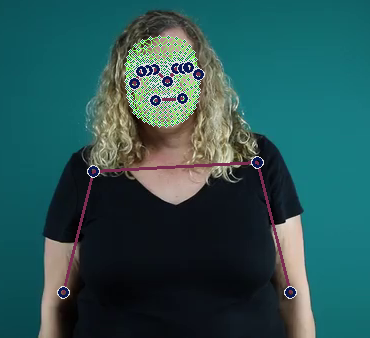

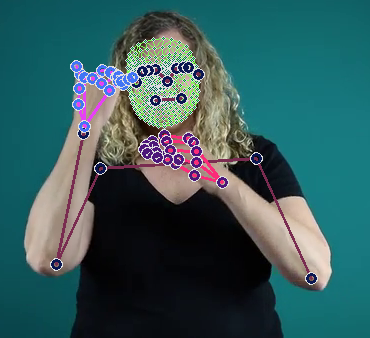

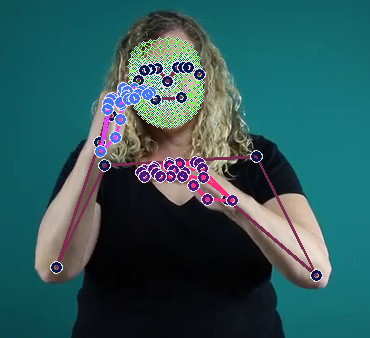

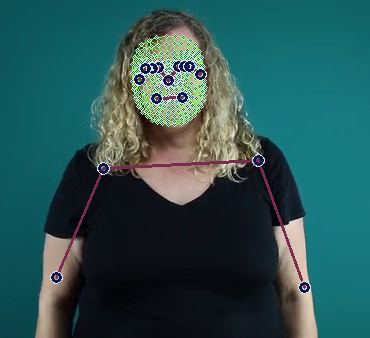

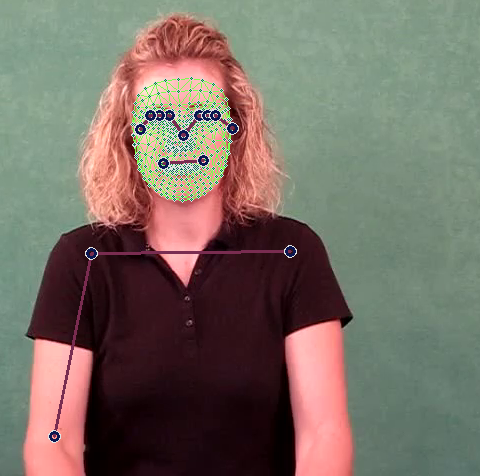

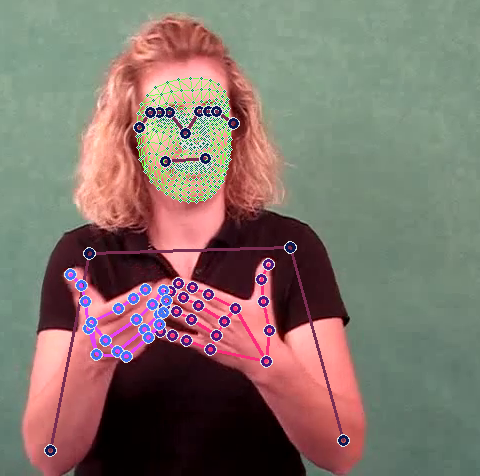

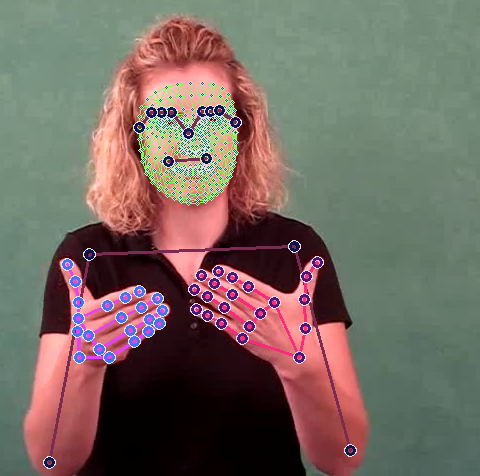

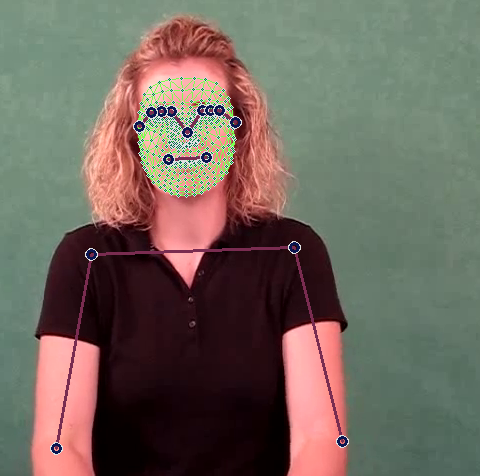

In [6]:
# 0.1% of the data for quick exploration, will change later
videos = data_info.loc[data_info.split=='train'].sample(frac=0.01,random_state=1)
videos

for inx in data_info.loc[data_info.split=='train'].sample(frac=0.001,random_state=1).index:
  video_file = os.path.join(working_dir,'videos',data_info.loc[inx,'video_id']+'.mp4')
  cap = cv2.VideoCapture(video_file)
  # Set mediapipe model
  ret, frame = cap.read()
  i = -1 # Sampling the frames
  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
      while True:
          i += 1
          # Read feed
          ret, frame = cap.read()
          if not ret:
            break
          if i % int(cap.get(cv2.CAP_PROP_FRAME_COUNT)/3) != 0: # Show 4 frames as sample
            continue
          x, y, h, w = json.loads(data_info.loc[inx,'bbox'])
          #cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
          bounded_frame = frame[y:y+h, x:x+w]
          # Make detections
          image, results = mediapipe_detection(bounded_frame, holistic)
          # Draw landmarks
          draw_styled_landmarks(image, results)
          cv2_imshow(image) # For Colab
          # cv2.imshow('OpenCV Feed', image) # For computer
          i += 1
      cap.release()
#      cv2.destroyAllWindows() # If cv2.imshow('OpenCV Feed', image) is used
  cap.release()
